<a href="https://colab.research.google.com/github/PatilVaishnav131/disease-prediction-ai/blob/main/Malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Malaria Detection using Deep Learing
Steps:
1.
2.
3.
4.
We'll be using YOLOv8 model for the malaria detection

In [ ]:
#Insalling YOLOv8
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [1]:
import zipfile
import os

# Set path where your ZIP is located
zip_path = '/content/drive/MyDrive/malaria_dataset/archive (2).zip'
extract_to = '/content/MalariaDataset'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# List top-level folders
os.listdir(extract_to)


['cell_images']

## Data visualization

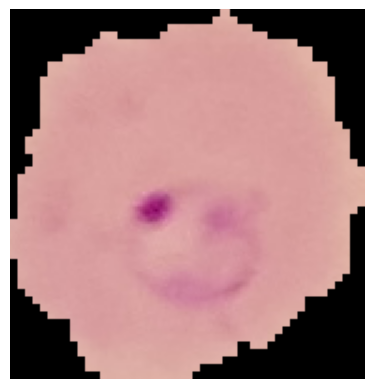

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/MalariaDataset/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png')
plt.imshow(img)
plt.axis('off') # Hide axes
plt.show()

In [5]:
"C100P61ThinF_IMG_20150918_144104_cell_162.png" == "C100P61ThinF_IMG_20150918_144104_cell_162.png"

True

In [7]:
import os

def count_images_in_directory(directory):
    image_extensions = {'.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp'}
    count = 0

    for file in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, file)):
            if os.path.splitext(file)[1].lower() in image_extensions:
                count += 1

    return count

# Example usage
directory_path = "/content/MalariaDataset/cell_images/Parasitized"
print("Number of images Parasitized:", count_images_in_directory(directory_path))
print("Number of images Uninfected:", count_images_in_directory("/content/MalariaDataset/cell_images/Uninfected"))
print("Total number of images:", count_images_in_directory(directory_path) + count_images_in_directory("/content/MalariaDataset/cell_images/Uninfected"))


Number of images Parasitized: 13779
Number of images Uninfected: 13779
Total number of images: 27558


## Data preparation

In [12]:
import shutil

# Path to the extra unwanted folder
unwanted_folder = '/content/MalariaDataset/cell_images/cell_images'
shutil.rmtree(unwanted_folder)  # This will remove the unwanted subfolder


In [13]:
img_size = (128, 128)
batch_size = 32
data_dir = '/content/MalariaDataset/cell_images'  # Use parent directory!

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


##Model importing

In [15]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=img_size+(3,))
base_model.trainable = False

tl_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
tl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


NameError: name 'models' is not defined

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers

# Load the MobileNetV2 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=img_size+(3,))
base_model.trainable = False  # Freeze the base model layers

# Build the transfer learning model
tl_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
tl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



## Training model

In [ ]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
mc = ModelCheckpoint('best_model.h5', save_best_only=True)

history = tl_model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[es, mc]
)
